# Introduction
This tutorial illustrates how to study the cost and effect by varying system parameters in OpenDss through Python. we will use a 3-phase 2-bus example as shown below. We will study the effect of (1) changing operation power of loads, (2) introducing unbalanced loads and (3) PV system installation. 
<span style='color:red'> Again, Please change the working directory in below First</span>.

In [3]:
import os
os.chdir('C:\\Users\\anson\\Desktop\\OpenDss Tutorial\\T3') 

In [4]:
import pandas as pd
import numpy as np
from cmath import rect
import opendssdirect as dss
import matplotlib as plt
nprect = np.vectorize(rect) #allow element-wise operation in array, detail see https://stackoverflow.com/questions/16444719/python-numpy-complex-numbers-is-there-a-function-for-polar-to-rectangular-co
dss.Basic.AllowEditor(False)

### (1) Effects of changing operation power
In this part, we will investigate how line-to-neutral voltages varies with operation power of loads in a balanced-loads system. The apparents power of loads will vary from 3 to 40 kVA with an increment of 3kVA

<AxesSubplot:xlabel='Load operation (kVA)', ylabel='line-to-Neutral Voltage (V)'>

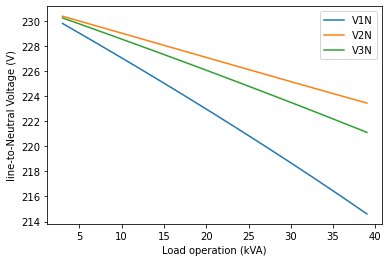

In [5]:
df=pd.DataFrame(columns=['kVA_Load','V1N','V2N','V3N']);
for kVA_Loads in range(3,40,3): #increment kVA rating of load2 by 3kVA
    dss.run_command('Redirect two_buses_balanced.dss')
    
    for loads in dss.utils.class_to_dataframe('load').index: # .index return the name of all loads in a list
        #change the load
        dss.run_command(loads+'.kVA='+str(kVA_Loads))
        
    dss.run_command('Solve')
    dss.run_command('Export Voltages original.csv')

    Voltages_data=pd.read_csv("original.csv",header=0).set_index('Bus');
    
    #get line to neutral voltage by complex substraction
    V_mag=V1,V2,V3,VN=(Voltages_data.loc['B2'])[[' Magnitude1',' Magnitude2',' Magnitude3',' Magnitude4']];
    V_angle=A1,A2,A3,AN=(Voltages_data.loc['B2'])[[' Angle1',' Angle2',' Angle3',' Angle4']];
    Z_V1,Z_V2,Z_V3,Z_VN = nprect(V_mag, np.deg2rad(V_angle));
    V1N,V2N,V3N=np.absolute([Z_V1,Z_V2,Z_V3]-Z_VN);

    result={'kVA_Load':kVA_Loads ,'V1N':V1N ,'V2N':V2N ,'V3N': V3N };
    df=df.append(result,ignore_index=True);

df.plot(x='kVA_Load',y=['V1N','V2N','V3N'],ylabel='line-to-Neutral Voltage (V)',xlabel=('Load operation (kVA)'))

We can see that line-to-neutral (V_N) voltages increases with lower kVA values of loads. When kVA values is too low, the line to neutral voltage can be higher than the base voltage of 230V. This phenonmenon is known as <span style='color:red'> Ferranti effect</span> caused by reactive power generated from line capactiance. Employing larger loads can help to absorb the reactive power and hence lowering the line-to-neutral voltage.

Lastly, although loads are balanced in the circuit, the value of V_N are not the same for different phases. The reason is line geometry of tranmsission line is not in the shape of equidistant triagnle so the shunt capacitance for each phase are not the same. looking at the text file 'AusOverhead_nr_linegeometry_balanced_PropertyDump', we can see that the values in the B matrix, B_14, B_24 and B_23 (and G_14, G_24 and G_23 in G matrix) that correponds to line-to-neutral admittance of different phases are not the same. 

In [6]:
dss.run_command('dump line.* debug')

'C:\\Users\\anson\\Desktop\\OpenDss Tutorial\\T3\\AusOverhead_nr_linegeometry_balanced_PropertyDump.Txt'

### (2) Effects of unbalanced loads
Now, we will investigate the effect of changing only the load at the second phase in an unbalanced-load system.  

<AxesSubplot:xlabel='Load2 operation (kVA)', ylabel='line-to-Neutral Voltage (V)'>

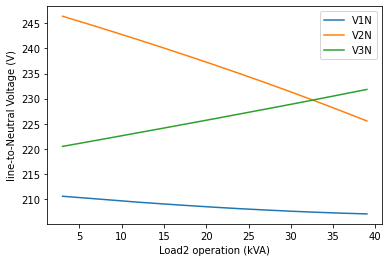

In [7]:
df=pd.DataFrame(columns=['kVA_Load2','V1N','V2N','V3N']);
for kVA_Load2 in range(3,40,3): #increment kVA value of load2 by 3kVA
    dss.run_command('Redirect two_buses_unbalanced.dss')
    
    dss.run_command('Load.LoadP2.kVA='+str(kVA_Load2))
        
    dss.run_command('Solve')
    dss.run_command('Export Voltages original.csv')

    Voltages_data=pd.read_csv("original.csv",header=0).set_index('Bus');
    #get line to neutral voltage by complex substraction
    V_mag=V1,V2,V3,VN=(Voltages_data.loc['B2'])[[' Magnitude1',' Magnitude2',' Magnitude3',' Magnitude4']];
    V_angle=A1,A2,A3,AN=(Voltages_data.loc['B2'])[[' Angle1',' Angle2',' Angle3',' Angle4']];
    Z_V1,Z_V2,Z_V3,Z_VN = nprect(V_mag, np.deg2rad(V_angle));
    V1N,V2N,V3N=np.absolute([Z_V1,Z_V2,Z_V3]-Z_VN);

    result={'kVA_Load2':kVA_Load2 ,'V1N':V1N ,'V2N':V2N ,'V3N': V3N };
    df=df.append(result,ignore_index=True);

df.plot(x='kVA_Load2',y=['V1N','V2N','V3N'],ylabel='line-to-Neutral Voltage (V)',xlabel=('Load2 operation (kVA)'))

Similarly, we can see that increasing the kVA value of load_2 lowers the value of line-to-neutral voltage for the 2nd phase. However, rise of voltage is shown for load at the 1st phase whereas fall of voltage is seen for load at the 3rd-phase. This is because the voltage at neutral wire changes which in turn affects the voltages across the other loads. Therefore, altering a load in a network will impact other loads at the same time.

### (3) Effects of PV system installation
Lastly, we will investigate the effect of changing the PV capacity in a balanced system. Pmpp is the active power generated by solar panels under irradiance of 1000W/m^2

<AxesSubplot:xlabel='Pmpp (kW)', ylabel='line-to-Neutral Voltage (V) (V)'>

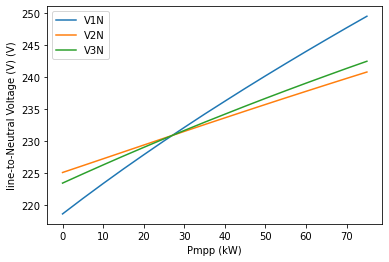

In [8]:
df=pd.DataFrame(columns=['Pmpp','V1N','V2N','V3N']);

for Pmpp in range(0,80,5): #increment maximum output power of PV by 5kW
    kVA_rating=round(Pmpp/0.9,1); #adjust kVA according to Pmpp
    dss.run_command('Redirect two_buses_balanced_PV.dss');
    
    for PVsystem in dss.utils.class_to_dataframe('PVsystem').index: # .index return the name of all PVsystem in a list
        #change the PVsystem parameters
        dss.run_command(PVsystem+'.Pmpp='+str(Pmpp));  
        dss.run_command(PVsystem+'.kVA='+str(kVA_rating));

    dss.run_command('Solve')
    dss.run_command('Export Voltages balanced.csv')

    Voltages_data=pd.read_csv("balanced.csv",header=0).set_index('Bus');
    #get line to neutral voltage by complex substraction
    V_mag=V1,V2,V3,VN=(Voltages_data.loc['B2'])[[' Magnitude1',' Magnitude2',' Magnitude3',' Magnitude4']];
    V_angle=A1,A2,A3,AN=(Voltages_data.loc['B2'])[[' Angle1',' Angle2',' Angle3',' Angle4']];
    Z_V1,Z_V2,Z_V3,Z_VN = nprect(V_mag, np.deg2rad(V_angle));
    V1N,V2N,V3N=np.absolute([Z_V1,Z_V2,Z_V3]-Z_VN);

    result={'Pmpp':Pmpp ,'V1N':V1N ,'V2N':V2N ,'V3N': V3N };
    df=df.append(result,ignore_index=True);
    
df.plot(x='Pmpp',y=['V1N','V2N','V3N'],ylabel='line-to-Neutral Voltage (V) (V)',xlabel='Pmpp (kW)')

As expected, the line-to-neutral voltages increases with the capacity of a PV system. Because the PV generation compensates the power drawn by the loads, resulting in apparent Ferranti effect when the power drawn from the network is too low. Once the PV generation exceeds the load consumption, voltage further increases in order to output higher power from PV system to the grid. 